In [ ]:
import torch 
import torchvision 
import torch.nn as nn 
import torch.optim as optim 
import torchvision.transforms as transforms 
from torchvision import models as models
import torch.nn.functional as F 

from torch.utils.data import Dataset 
from torch.utils.data import DataLoader 

import cv2 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib
import seaborn as sns
matplotlib.style.use('ggplot')

from tqdm import tqdm
import os 

from torch.utils.tensorboard import SummaryWriter 

### 1. Read data

In [ ]:
path = '/home/tungnguyendinh/.fastai/data/pascal_2007/'

train_data = pd.read_csv(os.path.join(path, 'train.csv'), sep = ",")
test_data = pd.read_csv(os.path.join(path, 'test.csv'), sep = ",")

In [ ]:
train_ratio = train_data.shape[0]   
test_ratio = test_data.shape[0]

print(train_ratio)
print(test_ratio)

5011
4952


In [ ]:
val_data = train_data.loc[train_data["is_valid"] == True] 
training_data = train_data.loc[train_data["is_valid"] == False]     

print(f"Validation data size: {val_data.shape[0]}")
print(f"Training data size: {training_data.shape[0]}")
print(f"Total size of train data: {train_data.shape[0]}")

Validation data size: 2510
Training data size: 2501
Total size of train data: 5011


### 2. Extract all train labels into a list 

#### 2.1. Extract all train labels into a list 

In [ ]:
train_labels = list(train_data['labels'])   # transform Series to list
train_labels = list(set(train_labels))      

all_labels = []
for label in train_labels: 
    label = label.split()
    for single_label in label: 
        if single_label not in all_labels: 
            all_labels.append(single_label)
            
print(all_labels)
print(f"Total number of distinct labels: {len(all_labels)}")

['sheep', 'bottle', 'person', 'sofa', 'pottedplant', 'chair', 'tvmonitor', 'cat', 'car', 'motorbike', 'cow', 'horse', 'dog', 'diningtable', 'bus', 'aeroplane', 'boat', 'bicycle', 'bird', 'train']
Total number of distinct labels: 20


### 2.2. One hot coding for the entire data 

In [ ]:
# structure of the table: fname, all_labels

val_data = train_data.loc[train_data["is_valid"] == True] 
training_data = train_data.loc[train_data["is_valid"] == False]     

print(training_data.shape)
print(val_data.shape)
print(test_data.shape)

data_size = [training_data.shape[0], val_data.shape[0], test_data.shape[0]]
print(data_size)

(2501, 3)
(2510, 3)
(4952, 2)
[2501, 2510, 4952]


In [ ]:
# create one hot coding table 
from sklearn.preprocessing import MultiLabelBinarizer


mlb = MultiLabelBinarizer()

all_image_labels = pd.concat([training_data[['fname', 'labels']], val_data[['fname', 'labels']], test_data], axis = 0)
print(all_image_labels.head(10))

all_labels = list(all_image_labels['labels'])
fname = list(all_image_labels['fname'])
print(fname[:10])
print(all_labels[:10])
print(f"Size of all labels: {len(all_labels)}")

for i in range(len(all_labels)): 
    all_labels[i] = tuple(all_labels[i].split())
    
print(all_labels[:5])

table = mlb.fit_transform(all_labels)

print(f"The number of distinct labels: {len(mlb.classes_)}")
print(table)
print(mlb.classes_)

         fname              labels
3   000012.jpg                 car
5   000017.jpg        person horse
9   000023.jpg      bicycle person
11  000026.jpg                 car
13  000032.jpg    aeroplane person
14  000033.jpg           aeroplane
15  000034.jpg               train
16  000035.jpg  person diningtable
17  000036.jpg                 dog
20  000042.jpg               train
['000012.jpg', '000017.jpg', '000023.jpg', '000026.jpg', '000032.jpg', '000033.jpg', '000034.jpg', '000035.jpg', '000036.jpg', '000042.jpg']
['car', 'person horse', 'bicycle person', 'car', 'aeroplane person', 'aeroplane', 'train', 'person diningtable', 'dog', 'train']
Size of all labels: 9963
[('car',), ('person', 'horse'), ('bicycle', 'person'), ('car',), ('aeroplane', 'person')]
The number of distinct labels: 20
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
['aeroplane' 'bicycle' 'bird' 'boat' 'bottle' 'bus' 'car' 'cat' 'chair'
 'co

### 3. Define Dataset Class

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, table, fname, data_size, train, test):
        self.all_labels = table                                      # one hot table 
        self.all_image_names = fname                                 # extract all the image file names 
        
        self.train = train
        self.test = test
        
        self.train_ratio = data_size[0]              
        self.valid_ratio = data_size[1]
        self.test_ratio = data_size[2]

        # define and prepare our training data: 
        if self.train == True:
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = self.all_image_names[:self.train_ratio]                 # extract the training images (name)
            self.labels = np.array(self.all_labels[:self.train_ratio])                 # extract the training labels (vector form)

            # define the training transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),                 
                transforms.Resize((400, 400)),                 # image resize 
                transforms.RandomHorizontalFlip(p=0.5),        # random horizontal flip 
                transforms.RandomRotation(degrees=45),         # randomly rotating the images 
                transforms.ToTensor(),
            ])

        # define and prepare our validation data   
        elif self.train == False and self.test == False:
            print(f"Number of validation images: {self.valid_ratio}")
            
            self.image_names = list(self.all_image_names[self.train_ratio:(self.train_ratio + self.valid_ratio)])
            self.labels = list(self.all_labels[self.train_ratio:(self.train_ratio + self.valid_ratio)])

            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((400, 400)),     # just apply resize image 
                transforms.ToTensor(),
            ])

        # define and prepare our test data 
        elif self.test == True and self.train == False:
            self.image_names = list(self.all_image_names[-self.test_ratio:])
            self.labels = list(self.all_labels[-self.test_ratio:])

            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((400, 400)),     # just apply resize image 
                transforms.ToTensor(),
            ])

    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        # read the image according to the image file name 
        if self.train == True or self.test == False: 
            image = cv2.imread(f"/home/tungnguyendinh/.fastai/data/pascal_2007/train/{self.image_names[index]}")
        else: 
            image = cv2.imread(f"/home/tungnguyendinh/.fastai/data/pascal_2007/test/{self.image_names[index]}")
            
        # convert the image from BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # apply image transforms
        image = self.transform(image)      # transform the image to tensor 
        targets = self.labels[index]       # extract the label according to the index position (one hot vector)
        
        return {
            'image': torch.tensor(image, dtype = torch.float32),
            'label': torch.tensor(targets, dtype = torch.float32)
        }

### 4. Define model (pretrain ResNet50)

In [ ]:
class MLNet(nn.Module): 
    def __init__(self, pretrained, requires_grad): 
        super().__init__()
        
        self.model = models.resnet50(progress = True, pretrained = pretrained)
        
         # to freeze the hidden layers
        if requires_grad == False:
            for param in self.model.parameters():
                param.requires_grad = False

        # to train the hidden layers
        elif requires_grad == True:
            for param in self.model.parameters():
                param.requires_grad = True

        self.model.fc = nn.Linear(2048, 20)
        
    def forward(self, x): 
        return self.model(x) 


### 5. Define training and validation function 

In [ ]:
def train(model, dataloader, optimizer, criterion, train_data, device):
    print('Training')
    model.train()                  # get the model training mode 
    
    counter = 0                    # keep track of the number of batches per epoch 
    running_loss = torch.tensor(0.0).to(device)      
    running_corrects = torch.zeros(len(mlb.classes_)).to(device)
    running_total = torch.zeros(len(mlb.classes_)).to(device)
    
    for i, data in tqdm(enumerate(dataloader), total = int(len(train_data)/dataloader.batch_size)):
        images, labels_vectors = data['image'].to(device), data['label'].to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        outputs = torch.sigmoid(outputs)      # apply sigmoid activation to get all the outputs between 0 and 1
        preds = outputs.round()               # get the prediction 
        
        loss = criterion(outputs, labels_vectors)

        # backpropagation
        loss.backward()                      

        # update optimizer parameters
        optimizer.step()          
        
        running_loss += loss.item() * images.size(0)       # add the loss for the batch 
        running_corrects += torch.sum(preds == labels_vectors.data, dim = 0)
        running_total += labels_vectors.size(0)                
              
    epoch_loss = running_loss / running_total.sum()              # calculate the per epoch loss
    epoch_cls_acc = running_corrects.double() / running_total * 100
    epoch_acc = epoch_cls_acc.mean()
    
    # Logging 
    print(f'Loss: {epoch_loss:.6f} Accuracy: {epoch_acc:.2f}%\n')
    writer.add_scalar("Train/loss", epoch_loss, epoch)
    writer.add_scalar("Train/accuracy/average", epoch_acc, epoch)

    
    return epoch_loss


In [ ]:
def validate(model, dataloader, criterion, val_data, device):
    print('Validating')

    model.eval()
    counter = 0
    running_loss = torch.tensor(0.0).to(device)
    running_corrects = torch.zeros(len(mlb.classes_)).to(device)
    running_total = torch.zeros(len(mlb.classes_)).to(device)

    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total = int(len(val_data)/dataloader.batch_size)):  
            images, labels_vectors = data['image'].to(device), data['label'].to(device)
        
            outputs = model(images)               
            outputs = torch.sigmoid(outputs)      # apply sigmoid activation to get all the outputs between 0 and 1
            preds = outputs.round()               # get the prediction 
            
            loss = criterion(outputs, labels_vectors)
            
            running_loss += loss.item() * images.size(0)       # add the loss for the batch 
            running_corrects += torch.sum(preds == labels_vectors.data, dim = 0)
            running_total += labels_vectors.size(0)                

        epoch_loss = running_loss / running_total.sum()              # calculate the per epoch loss
        epoch_cls_acc = running_corrects.double() / running_total * 100
        epoch_acc = epoch_cls_acc.mean()
        
        # Logging 
        print(f'Loss: {epoch_loss:.6f} Accuracy: {epoch_acc:.2f}%\n')  
        writer.add_scalar("Validation/loss", epoch_loss, epoch)
        writer.add_scalar("Validation/accuracy/average", epoch_acc, epoch)

        
        return epoch_loss


### 6. Start training and validating 

In [ ]:
# 1. initialize the computation device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# initialize the model 
# model = create_model(pretrained = True, requires_grad = False).to(device)
model = MLNet(pretrained = True, requires_grad = False).to(device)

# Tensorboard writer
writer = SummaryWriter("runs/MultiLabelsClassifier")

# Add model graph to Tensorboard
# writer.add_graph(model)

lr = 0.001
epochs = 20                 
batch_size = 32
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9)       
criterion = nn.BCELoss()      

train_data = ImageDataset(table, fname, data_size, train = True, test = False)
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)

valid_data = ImageDataset(table, fname, data_size, train = False, test = False)
valid_loader = DataLoader(valid_data, batch_size = batch_size, shuffle = False)

test_data = ImageDataset(table, fname, data_size, train = False, test = True)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False)


/home/haonguyenduy/Training/haongnvenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/haonguyenduy/Training/haongnvenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of training images: 2501
Number of validation images: 2510


In [ ]:
# 3. start the loop for training and validation 
train_loss = []
valid_loss = []

for epoch in range(epochs): 
    print(f"Epoch {epoch+1} of {epochs}:")

    train_epoch_loss = train(model, train_loader, optimizer, criterion, train_data, device)
    valid_epoch_loss = validate(model, valid_loader, criterion, val_data, device)
    
    # append the training and validation loss values in the train_loss and valid_loss lists, respectively
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    
writer.close()

Epoch 1 of 20:
Training


  0%|          | 0/78 [00:00<?, ?it/s]/tmp/ipykernel_13570/3599161398.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype = torch.float32),
79it [00:41,  1.90it/s]                        


Loss: 0.018227 Accuracy: 86.82%

Validating


79it [00:38,  2.08it/s]                        


Loss: 0.012648 Accuracy: 92.32%

Epoch 2 of 20:
Training


79it [00:37,  2.09it/s]                        


Loss: 0.012369 Accuracy: 92.07%

Validating


79it [00:34,  2.30it/s]                        


Loss: 0.012093 Accuracy: 92.62%

Epoch 3 of 20:
Training


79it [00:36,  2.18it/s]                        


Loss: 0.012079 Accuracy: 92.36%

Validating


79it [00:34,  2.31it/s]                        


Loss: 0.011816 Accuracy: 92.73%

Epoch 4 of 20:
Training


79it [00:36,  2.16it/s]                        


Loss: 0.011896 Accuracy: 92.51%

Validating


79it [00:33,  2.34it/s]                        


Loss: 0.011620 Accuracy: 92.96%

Epoch 5 of 20:
Training


79it [00:37,  2.12it/s]                        


Loss: 0.011725 Accuracy: 92.66%

Validating


79it [00:34,  2.28it/s]                        


Loss: 0.011443 Accuracy: 93.14%

Epoch 6 of 20:
Training


79it [00:37,  2.12it/s]                        


Loss: 0.011569 Accuracy: 92.82%

Validating


79it [00:34,  2.26it/s]                        


Loss: 0.011292 Accuracy: 93.23%

Epoch 7 of 20:
Training


79it [00:38,  2.06it/s]                        


Loss: 0.011428 Accuracy: 92.98%

Validating


79it [00:35,  2.20it/s]                        


Loss: 0.011116 Accuracy: 93.18%

Epoch 8 of 20:
Training


79it [00:37,  2.11it/s]                        


Loss: 0.011278 Accuracy: 92.99%

Validating


79it [00:34,  2.31it/s]                        


Loss: 0.010965 Accuracy: 93.28%

Epoch 9 of 20:
Training


79it [00:36,  2.14it/s]                        


Loss: 0.011124 Accuracy: 92.99%

Validating


79it [00:34,  2.27it/s]                        


Loss: 0.010803 Accuracy: 93.36%

Epoch 10 of 20:
Training


79it [00:36,  2.14it/s]                        


Loss: 0.010982 Accuracy: 93.12%

Validating


79it [00:34,  2.31it/s]                        


Loss: 0.010656 Accuracy: 93.36%

Epoch 11 of 20:
Training


79it [00:36,  2.16it/s]                        


Loss: 0.010873 Accuracy: 93.15%

Validating


79it [00:34,  2.29it/s]                        


Loss: 0.010531 Accuracy: 93.39%

Epoch 12 of 20:
Training


79it [00:36,  2.15it/s]                        


Loss: 0.010768 Accuracy: 93.11%

Validating


79it [00:35,  2.25it/s]                        


Loss: 0.010408 Accuracy: 93.42%

Epoch 13 of 20:
Training


79it [00:38,  2.05it/s]                        


Loss: 0.010607 Accuracy: 93.26%

Validating


79it [00:36,  2.17it/s]                        


Loss: 0.010278 Accuracy: 93.45%

Epoch 14 of 20:
Training


79it [00:38,  2.05it/s]                        


Loss: 0.010491 Accuracy: 93.20%

Validating


79it [00:37,  2.09it/s]                        


Loss: 0.010152 Accuracy: 93.51%

Epoch 15 of 20:
Training


79it [00:42,  1.85it/s]                        


Loss: 0.010402 Accuracy: 93.22%

Validating


79it [00:47,  1.67it/s]                        


Loss: 0.010027 Accuracy: 93.54%

Epoch 16 of 20:
Training


79it [00:38,  2.03it/s]                        


Loss: 0.010269 Accuracy: 93.24%

Validating


79it [00:36,  2.17it/s]                        


Loss: 0.009915 Accuracy: 93.57%

Epoch 17 of 20:
Training


79it [00:38,  2.05it/s]                        


Loss: 0.010199 Accuracy: 93.30%

Validating


79it [00:47,  1.68it/s]                        


Loss: 0.009817 Accuracy: 93.63%

Epoch 18 of 20:
Training


79it [00:39,  1.98it/s]                        


Loss: 0.010078 Accuracy: 93.33%

Validating


79it [00:36,  2.16it/s]                        


Loss: 0.009726 Accuracy: 93.65%

Epoch 19 of 20:
Training


79it [00:39,  2.00it/s]                        


Loss: 0.009993 Accuracy: 93.33%

Validating


79it [00:48,  1.64it/s]                        


Loss: 0.009568 Accuracy: 93.72%

Epoch 20 of 20:
Training


79it [00:38,  2.03it/s]                        


Loss: 0.009897 Accuracy: 93.41%

Validating


79it [00:36,  2.18it/s]                        

Loss: 0.009500 Accuracy: 93.77%



In [ ]:
# save the trained model to disk 
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, './model5.pth')

### 7. Test the trained model 

#### 7.1. Initialize the computation device and load the trained model 

In [ ]:
# initialize the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#intialize the model
model = MLNet(False, False).to(device)

# load the model checkpoint
checkpoint = torch.load('./model5.pth')

# load model weights state_dict
model.load_state_dict(checkpoint['model_state_dict'])

/home/haonguyenduy/Training/haongnvenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

### Test the model

In [ ]:
model.eval()

running_loss = torch.tensor(0.0).to(device)
running_corrects = torch.zeros(len(mlb.classes_)).to(device)
running_total = torch.zeros(len(mlb.classes_)).to(device)


for i, data in tqdm(enumerate(test_loader), total = int(len(test_data)/test_loader.batch_size)): 
    images, labels_vectors = data['image'].to(device), data['label'].to(device)
    
    with torch.no_grad():                               
        outputs = model(images)                          
        outputs = torch.sigmoid(outputs)
        preds = outputs.round()
        loss = criterion(outputs, labels_vectors)
        
    # Statistics
    running_loss += loss.item() * images.size(0)
    running_corrects += torch.sum(preds == labels_vectors.data, dim = 0)
    running_total += labels_vectors.size(0)
    
loss = running_loss / running_total.sum()
cls_loss = running_corrects.double() / running_total * 100
acc = cls_loss.mean()

print('Loss: {:.4f} - Acc: {:.2f}%'.format(loss, acc))

  0%|          | 0/154 [00:00<?, ?it/s]/tmp/ipykernel_13570/3599161398.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype = torch.float32),
155it [01:13,  2.11it/s]                         

Loss: 0.0093 - Acc: 93.89%


### 8. View TensorBoard 

In [ ]:
!tensorboard --logdir=runs

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.9.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C


### Filter Visualization 

/tmp/ipykernel_13570/3599161398.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype = torch.float32),


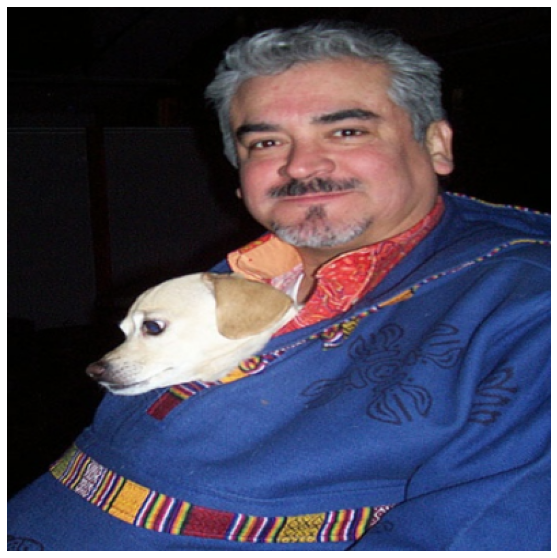

In [ ]:
# Test image  
image, label = test_data[0]['image'], test_data[0]['label']        # both torch.tensor type 

plt.figure(figsize=(10, 10))
plt.imshow(image.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
plt.show()

In [ ]:
print(label)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0.])


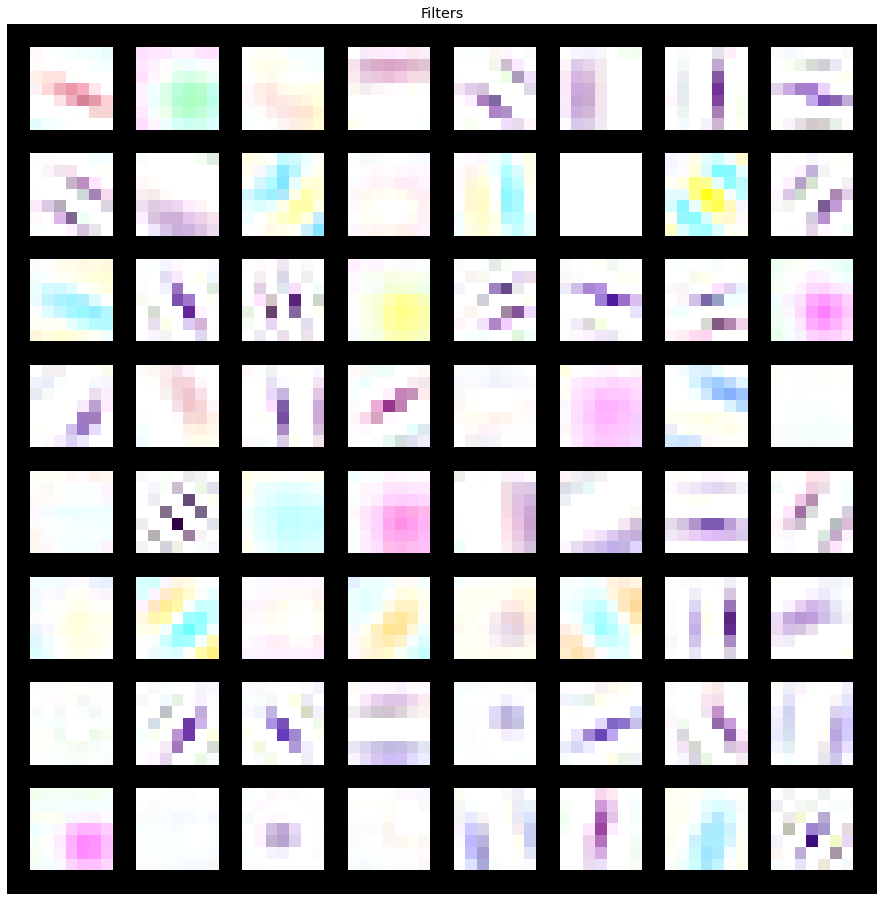

In [ ]:
# Visualize early kernels
kernels = model.model.conv1.weight.detach().cpu()

# Min max scale
kernels = (kernels - kernels.min()) / kernels.max()
filters = torchvision.utils.make_grid(kernels.clamp(0, 1))
writer.add_image('filters', filters)
filters = filters.permute(1, 2, 0)

plt.figure(figsize=(16, 16))    
plt.imshow(filters)
plt.savefig('filters.jpg', bbox_inches='tight')
plt.axis('off')
plt.title('Filters')
plt.show()

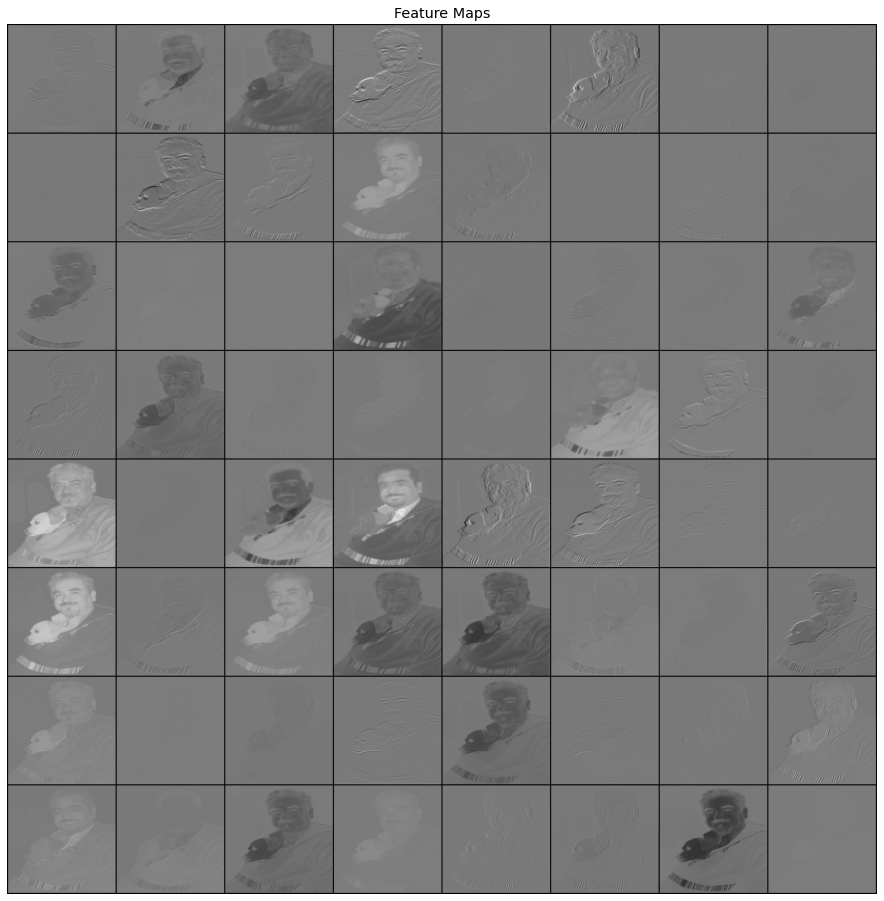

In [ ]:
# Visualize feature maps
kernels = model.model.conv1.weight.detach().cpu()

class FirstConv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 64, kernel_size=7, padding=3, stride=2)
    
    def forward(self, x):
        x = self.conv(x)
        return x
    
conv = FirstConv()
conv.conv.weight = nn.Parameter(kernels)
feature_maps = conv(image.unsqueeze(0)).detach()

# Min max scale
feature_maps = (feature_maps - feature_maps.min()) / feature_maps.max()
feature_maps = feature_maps[0].unsqueeze(1)

feature_grid = torchvision.utils.make_grid(feature_maps)
writer.add_image('feature maps', feature_grid)
feature_maps = feature_maps.numpy()

plt.figure(figsize=(16, 16))
plt.imshow(feature_grid[0], cmap='gray')
plt.axis('off')
plt.title('Feature Maps')
plt.show()
